# Projeto Machine Learning II – Classificação de Sons Urbanos

## 1. Contexto
O som urbano faz parte essencial do ambiente em que vivemos. A classificação automática de sons urbanos (como buzinas, sirenes ou crianças a brincar) é relevante para aplicações em **segurança**, **monitorização ambiental**, **cidades inteligentes** e **recuperação de multimédia**. Apesar da extensa pesquisa em áudio, poucos trabalhos lidam com **sons urbanos reais**, e a ausência de datasets padronizados dificulta a comparação de resultados.

## 2. Objetivo do Projeto
O objetivo deste projeto é desenvolver **classificadores de deep learning** capazes de identificar a qual das 10 classes pertence um trecho de áudio urbano. Para isso, serão implementados dois modelos de redes neurais à escolha entre **MLP, CNN e RNN**, permitindo avaliar e comparar o desempenho de cada um.

## 3. Dataset UrbanSound8K

### 3.1. Dataset metadata

- **slice_file_name**: O nome do ficheiro de áudio.
- **fsID**: O ID do Freesound da gravação de onde este excerto (slice) foi retirado.
- **start**: O momento inicial do excerto na gravação original do Freesound.
- **end**: O momento final do excerto na gravação original do Freesound.
- **salience**: Uma classificação (subjetiva) da importância do som.  
  - **1** = som em primeiro plano  
  - **2** = som de fundo
- **fold**: O número do *fold* (1–10) ao qual este ficheiro foi atribuído (usado em divisões de treino/teste).
- **classID**: Um identificador numérico da classe do som.
- **class**: O nome da classe do som (a etiqueta que descreve o tipo de som).


### 3.2 Propriedades do áudio digital

As principais características que descrevem áudio digital — e que queremos analisar neste notebook — são:

- **Canais**: número de canais de áudio (mono/estéreo).
- **Taxa de Amostragem (Sample Rate)**: número de amostras por segundo, expresso em quilohertz (kHz); está relacionado com a qualidade do áudio.
- **Profundidade de Bits (Bit Depth)**: equivalente à resolução em imagens; descreve o nível de detalhe.
- **Duração**: comprimento do som ao longo do tempo.

As várias propriedades do áudio apresentam formatos e estruturas distintos. O primeiro passo é perceber como cada uma delas se distribui no conjunto de dados e analisar de que forma podemos padronizá-las, por exemplo, convertendo-as.






In [4]:
#bibliotecas 

import librosa #install - !pip install librosa
import numpy as np
import pandas as pd
import os, json
from tqdm import tqdm
import random
import soundfile as sf
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
# from tensorflow.keras.utils import to_categorical # !pip install tensorflow

import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import seaborn as sns #install - !pip install seaborn


### 1. Exploratory Data Analysis – EDA

Nesta etapa, o objetivo é compreender melhor a estrutura e as características do conjunto de dados UrbanSound8K, verificando o tipo de informações disponíveis, se há valores ausentes, e como as classes estão distribuídas.
Isso é essencial para preparar o dataset antes de qualquer modelagem.

In [5]:
dataset_path = "/Users/leonorarreiol/Desktop/UrbanSound8K/audio"
metadata_file = "/Users/leonorarreiol/Desktop/UrbanSound8K/metadata/UrbanSound8K.csv"
metadata = pd.read_csv(metadata_file)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
# nameofclass = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

#### 1.1- Estatísticas Descritivas 
Fornece informações como médias, valores mínimos e máximos e quartis das colunas numéricas — útil para verificar a consistência dos dados, por exemplo, se start < end

In [7]:
metadata.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [8]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


O dataset não contém valores nulos, o que facilita a preparação

In [9]:
metadata.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

## 1.1 Análise da Distribuição das Classes

Está bem distribuido em 8 classes , mas conseguimos perceber que "car_horn" e "gun_shot" têm valores significativamente diferentes que os restantes. Pode ser um problema futuro

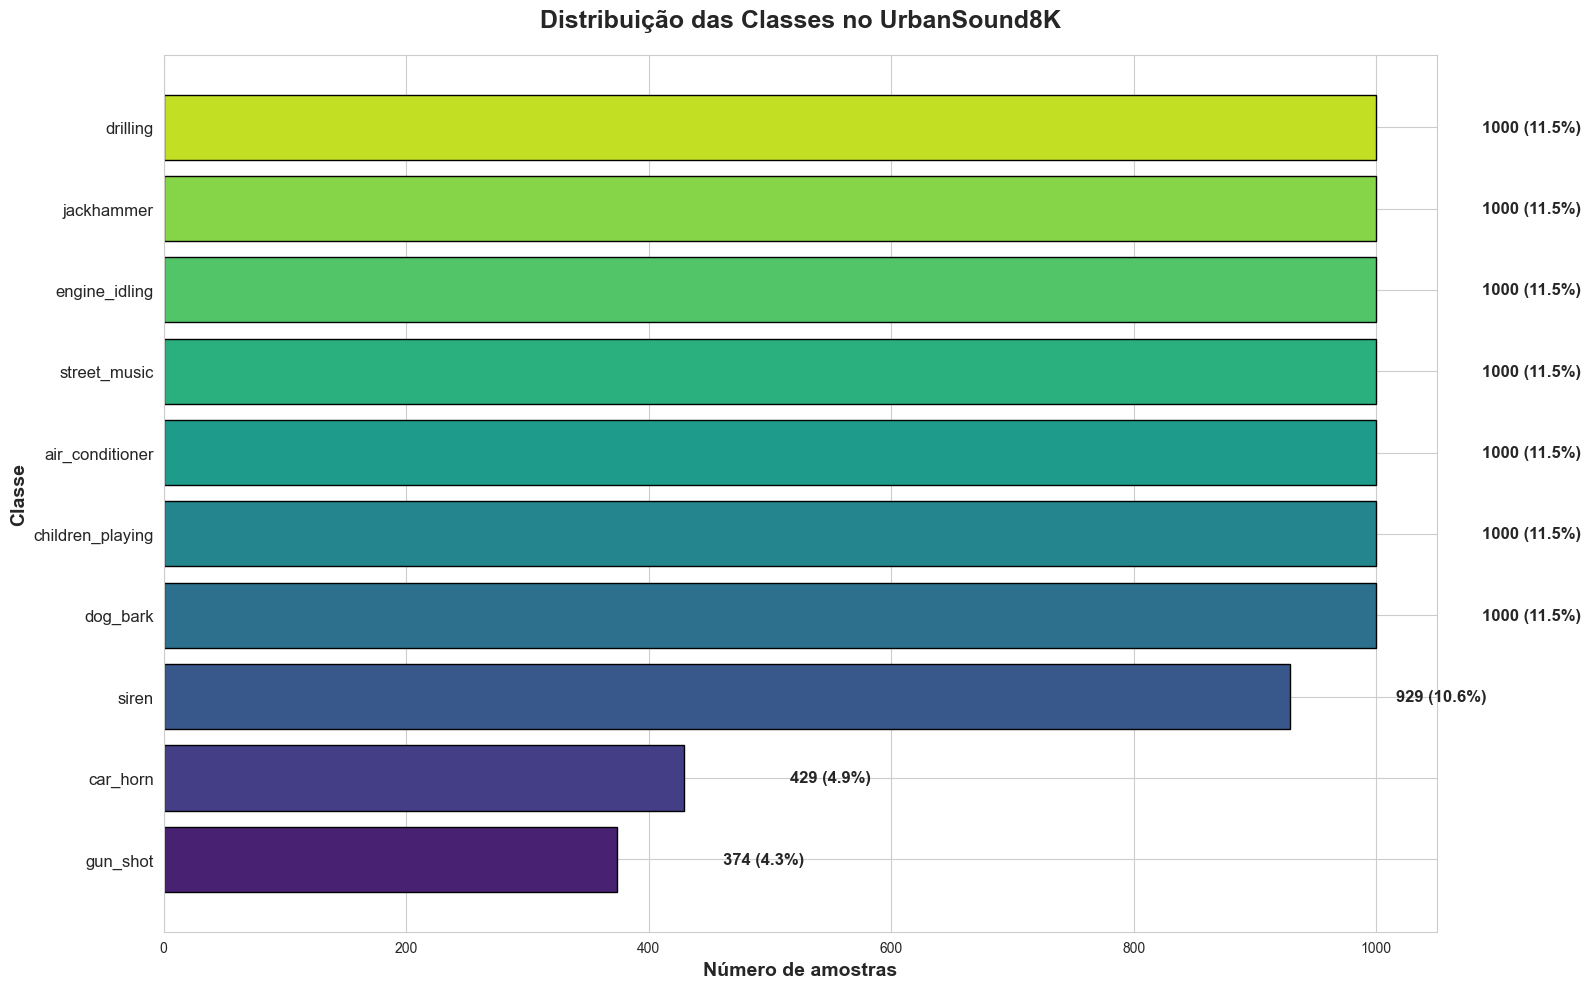

In [10]:
class_distribution = metadata['class'].value_counts().sort_values(ascending=True)
total_samples = class_distribution.sum()

plt.figure(figsize=(16, 10))  # figura maior para acomodar os nomes
sns.set_style("whitegrid")

# Paleta de cores graduais
colors = sns.color_palette("viridis", len(class_distribution))

# Criar gráfico de barras horizontais
bars = plt.barh(class_distribution.index, class_distribution.values, color=colors, edgecolor='black')

# Adicionar números e percentuais ao lado de cada barra
for bar, value in zip(bars, class_distribution.values):
    pct = value / total_samples * 100
    plt.text(value + total_samples*0.01, bar.get_y() + bar.get_height()/2, f"{value} ({pct:.1f}%)", 
             va='center', fontweight='bold', fontsize=12)

# Eixos e título
plt.xlabel("Número de amostras", fontsize=14, fontweight='bold')
plt.ylabel("Classe", fontsize=14, fontweight='bold')
plt.title("Distribuição das Classes no UrbanSound8K", fontsize=18, fontweight='bold', pad=20)

# Melhorar legibilidade dos nomes das classes
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## 1.2 Propriedades do áudio

### 1.2.1 Comprimento do áudio

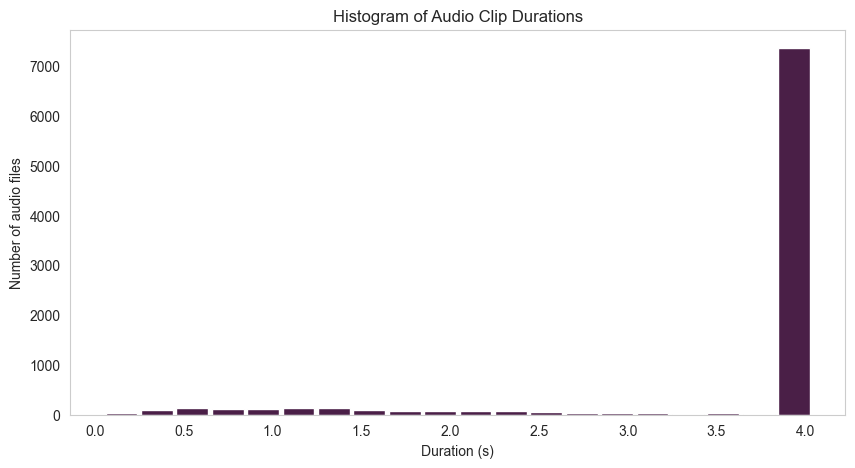

count    8732.000000
mean        3.607522
std         0.974394
min         0.050000
25%         4.000000
50%         4.000000
75%         4.000000
max         4.036647
Name: duration, dtype: float64


In [11]:
audio_durations = []

for idx, row in metadata.iterrows():
    fold = 'fold' + str(row["fold"])
    file_name = str(row["slice_file_name"])
    file_path = os.path.join(dataset_path, fold, file_name)
    
    # Carrega áudio (mantendo taxa original)
    waveform, sr = librosa.load(file_path, sr=None)
    
    # Calcula duração em segundos
    duration = len(waveform) / sr
    
    audio_durations.append((file_name, fold, row["class"], duration))

# Converte para DataFrame
durations_df = pd.DataFrame(audio_durations, columns=['file', 'fold', 'class', 'duration'])

# Histograma das durações
plt.figure(figsize=(10,5))
plt.hist(durations_df['duration'], bins=20, rwidth=0.9, color="#4a1f47")
plt.xlabel('Duration (s)')
plt.ylabel('Number of audio files')
plt.title('Histogram of Audio Clip Durations')
plt.grid(False)
plt.show()

# Estatísticas básicas
print(durations_df['duration'].describe())

### 1.2.2 Distribuição da frequência

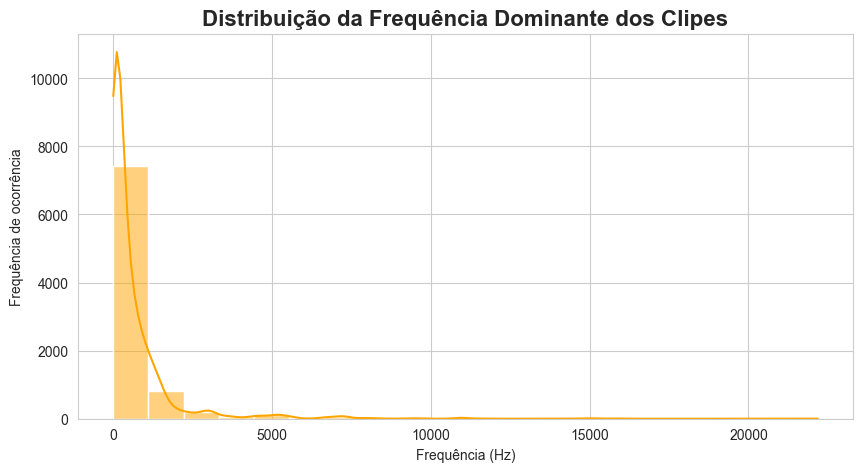

In [12]:
dominant_freqs = []

for index, row in metadata.iterrows():
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    waveform, sr = librosa.load(file_path, sr=None)
    
    # FFT do sinal
    fft = np.fft.fft(waveform)
    fft_magnitude = np.abs(fft)
    fft_freqs = np.fft.fftfreq(len(fft), 1/sr)
    
    # Frequência dominante (excluindo negativas)
    pos_mask = fft_freqs > 0
    dominant_freq = fft_freqs[pos_mask][np.argmax(fft_magnitude[pos_mask])]
    dominant_freqs.append(dominant_freq)

plt.figure(figsize=(10, 5))
sns.histplot(dominant_freqs, bins=20, kde=True, color='orange')
plt.title("Distribuição da Frequência Dominante dos Clipes", fontsize=16, fontweight='bold')
plt.xlabel("Frequência (Hz)")
plt.ylabel("Frequência de ocorrência")
plt.show()

Aqui decidimos ver a frequência mais promenorizadamente 

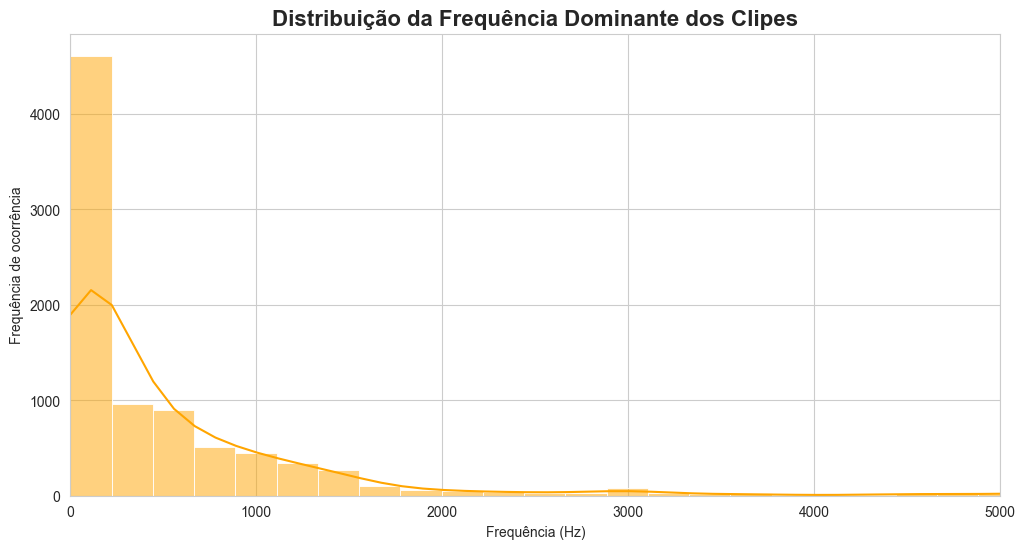

In [13]:
dominant_freqs = []

for index, row in metadata.iterrows():
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    waveform, sr = librosa.load(file_path, sr=None)
    
    # FFT do sinal
    fft = np.fft.fft(waveform)
    fft_magnitude = np.abs(fft)
    fft_freqs = np.fft.fftfreq(len(fft), 1/sr)
    
    # Frequência dominante (excluindo negativas)
    pos_mask = fft_freqs > 0
    dominant_freq = fft_freqs[pos_mask][np.argmax(fft_magnitude[pos_mask])]
    dominant_freqs.append(dominant_freq)

plt.figure(figsize=(12, 6))
sns.histplot(dominant_freqs, bins=100, kde=True, color='orange')  # bins aumentados para mais detalhes
plt.title("Distribuição da Frequência Dominante dos Clipes", fontsize=16, fontweight='bold')
plt.xlabel("Frequência (Hz)")
plt.ylabel("Frequência de ocorrência")
plt.xlim(0, 5000)  # Limita o eixo x para melhor visualizar os detalhes mais importantes
plt.show()


### 1.2.3 Profundidade de bits

  0%|          | 0/8732 [00:00<?, ?it/s]

100%|██████████| 8732/8732 [00:01<00:00, 4581.51it/s]


Contagem de bit depths:
bit_depth
16.0    5758
24.0    2753
32.0     169
Name: count, dtype: int64

Proporção de bit depths:
bit_depth
16.0    0.663364
24.0    0.317166
32.0    0.019470
Name: proportion, dtype: float64


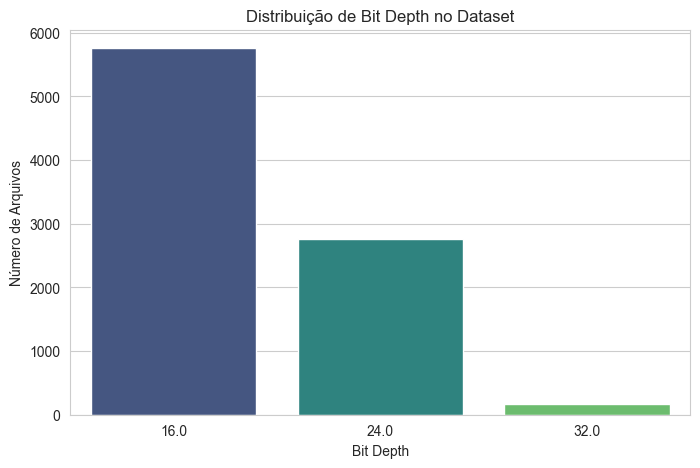

In [14]:
def check_audio_bit_depth(metadata, dataset_path):
    """
    Verifica o bit depth de todos os arquivos do dataset.
    Retorna um DataFrame com nome do arquivo, fold e bit depth.
    """
    data = []
    
    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
        file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
        
        # Lê informações do arquivo
        info = sf.info(file_path)
        subtype = info.subtype  # ex: 'PCM_16', 'PCM_24', 'U8', 'FLOAT', 'PCM_4'
        
        # Tenta extrair número do bit depth diretamente de qualquer string
        import re
        match = re.search(r'\d+', subtype)
        bit_depth = int(match.group()) if match else None
        
        data.append((row['slice_file_name'], row['fold'], bit_depth))
    
    df = pd.DataFrame(data, columns=['file', 'fold', 'bit_depth'])
    return df

def check_audio_bit_depth(metadata, dataset_path):
    """
    Verifica o bit depth de todos os arquivos do dataset.
    Retorna um DataFrame com nome do arquivo, fold e bit depth.
    """
    data = []

    def subtype_to_bits(subtype):
        subtype = subtype.upper()
        if subtype.startswith("PCM_"):
            try:
                return int(subtype.split("_")[1])
            except:
                return None
        elif subtype == "U8":
            return 8
        elif subtype == "FLOAT":
            return 32
        elif subtype in ["ALAW", "ULAW"]:
            return 8
        else:
            return None

    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
        file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
        info = sf.info(file_path)
        bit_depth = subtype_to_bits(info.subtype)
        data.append((row['slice_file_name'], row['fold'], bit_depth))

    df = pd.DataFrame(data, columns=['file', 'fold', 'bit_depth'])
    return df

# Executando a função
bit_depth_info = check_audio_bit_depth(metadata, dataset_path)

# Estatísticas
print("Contagem de bit depths:")
print(bit_depth_info['bit_depth'].value_counts())
print("\nProporção de bit depths:")
print(bit_depth_info['bit_depth'].value_counts(normalize=True))

# Plot da distribuição
plt.figure(figsize=(8,5))
sns.countplot(x='bit_depth', data=bit_depth_info, palette='viridis')
plt.xlabel("Bit Depth")
plt.ylabel("Número de Arquivos")
plt.title("Distribuição de Bit Depth no Dataset")
plt.show()


### 1.2.4 Análise do Número de Canais nos Arquivos de Áudio

Cada arquivo de áudio pode ter **um ou mais canais** de som:  

- **Mono**: apenas um canal de áudio. Todos os sons são misturados em um único canal.  
- **Estéreo**: dois canais de áudio separados, normalmente representando o som para os ouvidos esquerdo e direito.  

No dataset **UrbanSound8K**, a informação sobre o número de canais **não está presente no arquivo CSV de metadata**. Portanto, precisamos inspecionar os próprios arquivos de áudio para descobrir se são mono ou estéreo.  

Para isso, podemos utilizar a biblioteca `librosa` carregando os arquivos com `mono=False`, preservando os canais originais. A forma do array retornado indica o tipo de canal:

- Se `waveform.shape` for `(n_amostras,)` → **mono**  
- Se `waveform.shape` for `(2, n_amostras)` → **estéreo**  

Com isso, podemos gerar uma **nova coluna no DataFrame** indicando o tipo de cada arquivo de áudio, o que nos permite analisar a distribuição de arquivos mono e estéreo no dataset.  

> Observação: arquivos estéreo podem ser convertidos para mono por meio de uma média entre os dois canais, técnica comum em processamento de áudio, para simplificar a entrada em modelos de aprendizado de máquina.


100%|██████████| 8732/8732 [00:01<00:00, 5043.72it/s]

Contagem de canais:
channels
2    7993
1     739
Name: count, dtype: int64

Proporção de canais:
channels
2    0.915369
1    0.084631
Name: proportion, dtype: float64


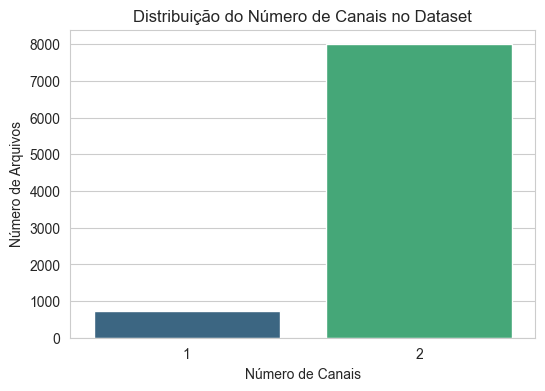

In [15]:
def check_audio_channels(metadata, dataset_path):
    """
    Verifica o número de canais de todos os arquivos do dataset.
    Retorna um DataFrame com nome do arquivo, fold e número de canais.
    """
    data = []
    
    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
        file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
        
        # Lê informações do arquivo
        info = sf.info(file_path)
        channels = info.channels  # Número de canais
        
        data.append((row['slice_file_name'], row['fold'], channels))
    
    df = pd.DataFrame(data, columns=['file', 'fold', 'channels'])
    return df

# Executando a função
channels_info = check_audio_channels(metadata, dataset_path)

# Estatísticas
print("Contagem de canais:")
print(channels_info['channels'].value_counts())
print("\nProporção de canais:")
print(channels_info['channels'].value_counts(normalize=True))

# Plot da distribuição de canais
plt.figure(figsize=(6,4))
sns.countplot(x='channels', data=channels_info, palette='viridis')
plt.xlabel("Número de Canais")
plt.ylabel("Número de Arquivos")
plt.title("Distribuição do Número de Canais no Dataset")
plt.show()


### 1.3 Explorar visual e auditivamente 

##### Exploração de Áudio

Visualizamos exemplos de áudio para **entender o comportamento dos sinais**, observar padrões de cada classe e orientar o **pré-processamento e extração de features** para os modelos de machine learning.


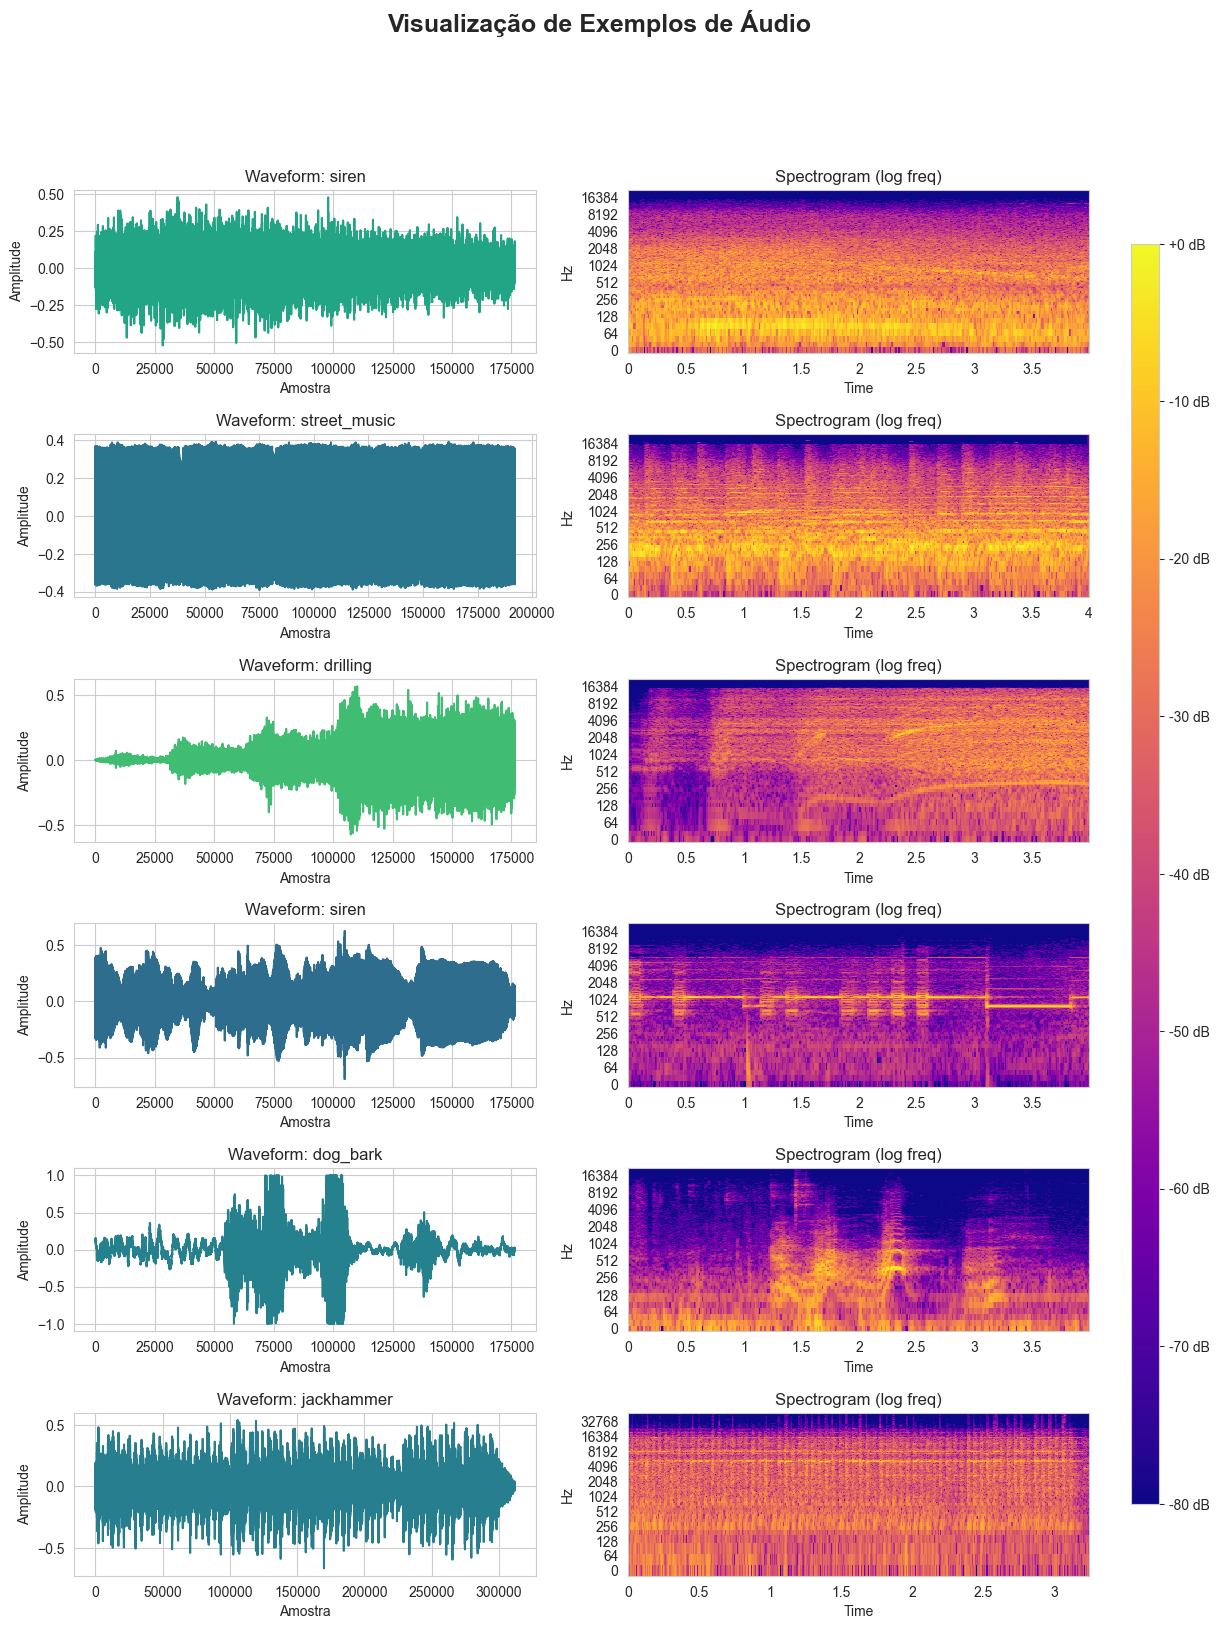

In [16]:
# Explorando múltiplos exemplos de áudio do dataset

import random
import librosa.display

# Selecionar 6 exemplos aleatórios do dataset
sample_rows = metadata.sample(6, random_state=42)

fig, axes = plt.subplots(6, 2, figsize=(14, 18))
fig.suptitle("Visualização de Exemplos de Áudio", fontsize=18, weight='bold')

for i, (_, row) in enumerate(sample_rows.iterrows()):
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    waveform, sr = librosa.load(file_path, sr=None)
    
    # 🎨 Forma de onda com cor aleatória suave
    axes[i, 0].plot(waveform, color=plt.cm.viridis(random.random()))
    axes[i, 0].set_title(f"Waveform: {row['class']}", fontsize=12)
    axes[i, 0].set_xlabel("Amostra")
    axes[i, 0].set_ylabel("Amplitude")
    
    # 🔥 Espectrograma logarítmico
    S = librosa.stft(waveform)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=axes[i, 1], cmap='plasma')
    axes[i, 1].set_title(f"Spectrogram (log freq)", fontsize=12)

# Ajuste de layout e colorbar
fig.subplots_adjust(right=0.85, hspace=0.5)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(img, cax=cbar_ax, format='%+2.0f dB')

plt.show()


### Interpretação do Waveform e Spectrograma

- **Waveform**: Mostra a amplitude do som ao longo do tempo. Picos indicam sons mais intensos, vales indicam sons mais suaves ou silêncio.  
- **Spectrograma**: Representa a intensidade do som em diferentes frequências ao longo do tempo. Cores mais fortes indicam maior energia em determinada frequência.

**Como isso ajuda na extração de features**:  
- Permite identificar padrões relevantes de cada classe de som.  
- Indica quais frequências e trechos temporais contêm mais informação, essenciais para calcular features como MFCCs ou Mel-spectrogramas.  
- Ajuda a decidir pré-processamentos úteis, como normalização e data augmentation.


Sons com padrões visuais distintos (por exemplo, “dog_bark” vs “siren”) facilitam a classificação automática.
Visualmente, já se consegue perceber se uma classe de som tende a ter energia concentrada em certas frequências ou períodos de tempo, o que orienta a escolha das features.

## Preprocessamento de Dados

## 2- Data Augumentation

#### 2.1 - Uniformizar a duração dos clipes e a taxa de amostragem

#### Por que escolhemos 22.050 Hz como taxa de amostragem

A **taxa de amostragem** (*sample rate*) indica quantas amostras de áudio são capturadas por segundo. Ela determina tanto a **qualidade do áudio** quanto a **faixa de frequências que podemos registrar**.  

De acordo com o **Teorema de Nyquist**, a maior frequência que podemos capturar é **metade da taxa de amostragem**.  
No caso de 22.050 Hz:

Ou seja, todas as frequências até 11.025 Hz são preservadas.

### Por que isso é suficiente para modelos de aprendizado de máquina

- A maior parte das informações importantes em sons (como fala, instrumentos ou efeitos sonoros) está nas **frequências baixas e médias**, abaixo de 11 kHz.  
- Reduzir a taxa de amostragem de arquivos originalmente maiores (44.100 Hz, 48 kHz, etc.) **diminui o tamanho dos dados** sem perder os padrões relevantes.  
- Isso **facilita o processamento**, seja para CNNs, MLPs ou outros modelos.



#### 2.2- Duração

Redes neurais convolucionais (CNNs) precisam receber dados com **relação espacial consistente**.  

- Em imagens, mudar a ordem das linhas ou colunas altera a informação e destrói a estrutura original.  
- Da mesma forma, no áudio, a relação entre **frequências e amplitudes ao longo do tempo** é essencial.  

Um dataset com durações diferentes significa **vetores de entrada de tamanhos variados**, o que não é compatível com CNNs.  

**Solução:** usamos **padding**:  
- Para amostras menores que a duração máxima do dataset, preenchemos o restante com **zeros**.  
- Esta técnica é muito comum e **não prejudica o desempenho da rede**, permitindo que todas as amostras tenham o mesmo tamanho.


#### 2.3 - Amplitude Máxima

É importante **normalizar a amplitude** dos arquivos de áudio.  
Isso garante que o modelo aprenda **padrões de forma consistente**, sem ser influenciado apenas pelo volume do som, e evita problemas com saturação das funções de ativação.

#### 2.4 - Profundidade de Bits (Bit Depth)

A **profundidade de bits** define a **resolução de cada amostra de áudio**.  
- Maior bit depth → mais detalhes e maior faixa dinâmica.  
- Menor bit depth → menos precisão e mais ruído perceptível.  

Converter bit depths **não é problemático**, de forma semelhante à conversão da taxa de amostragem.


#### 2.5 - Mono

Para consistência no dataset, todos os arquivos são convertidos para **mono**.  
- Isso garante que cada amostra tenha **uma única forma de onda**, facilitando o processamento por qualquer modelo (MLP ou CNN).  
- Evita complicações com múltiplos canais que poderiam alterar os padrões de áudio que a rede aprende.


In [17]:

def load_mono_resample_and_fix(file_path, target_sr=22050, target_duration=4.0):
    target_length = int(target_sr * target_duration)
    
    # Carrega áudio, garante mono e faz resampling
    waveform, sr = librosa.load(file_path, sr=target_sr, mono=True)
    
    # Ajusta duração (padding ou corte)
    if len(waveform) < target_length:
        waveform = np.pad(waveform, (0, target_length - len(waveform)), mode='constant')
    else:
        waveform = waveform[:target_length]
    
    # Normaliza valores para [-1, 1]
    if np.max(np.abs(waveform)) > 0:
        waveform = waveform / np.max(np.abs(waveform))
    
    return waveform, sr


In [18]:
audio_data = []

for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    
    # Carrega e processa áudio
    waveform, sr = load_mono_resample_and_fix(file_path, target_sr=22050, target_duration=4.0)
    duration = len(waveform) / sr
    
    # Adiciona ao dataset
    audio_data.append({
        "file": row['slice_file_name'],
        "fold": row['fold'],
        "class": row['class'],
        "waveform": waveform,
        "sr": sr,
        "duration": duration
    })

# Cria DataFrame final
audio_df = pd.DataFrame(audio_data)


100%|██████████| 8732/8732 [00:46<00:00, 185.91it/s]


#### Extração de features para MLP


Um MLP espera vetores 1-D (fixos) por amostra. Como o áudio é uma sequência (tempo × frequência), transformamos cada clipe num vetor resumo de características que captem informação timbral e temporal (por exemplo: MFCCs agregados, energia, ZCR, centroid).

#### 1.1 - Mel-Frequency Cepstral Coefficients (MFCCs)

In [19]:
TARGET_SR = 22050
TARGET_DURATION = 4.0   # segundos
N_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512
RANDOM_STATE = 42

# Função: carrega, resample, mono, pad/crop e normaliza amplitude para [-1,1]
def load_resample_mono_fix(path, target_sr=TARGET_SR, target_duration=TARGET_DURATION):
    target_len = int(target_sr * target_duration)
    y, sr = librosa.load(path, sr=target_sr, mono=True)  # resample + mono
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)), mode='constant')
    else:
        y = y[:target_len]
    max_abs = np.max(np.abs(y))
    if max_abs > 0:
        y = y / max_abs
    return y, sr

# Função: extrai features agregadas (1D vector) a partir de uma waveform
def extract_mlp_features(y, sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH):
    feats = []

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std  = np.std(mfcc, axis=1)
    feats.extend(mfcc_mean)
    feats.extend(mfcc_std)

    # MFCC deltas
    mfcc_delta = librosa.feature.delta(mfcc)
    delta_mean = np.mean(mfcc_delta, axis=1)
    delta_std  = np.std(mfcc_delta, axis=1)
    feats.extend(delta_mean)
    feats.extend(delta_std)

    # Spectral centroid, bandwidth, rolloff (mean + std)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    feats.append(np.mean(centroid)); feats.append(np.std(centroid))
    feats.append(np.mean(bandwidth)); feats.append(np.std(bandwidth))
    feats.append(np.mean(rolloff)); feats.append(np.std(rolloff))

    # RMS (energia) and ZCR (texture) - mean + std
    rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)
    feats.append(np.mean(rms)); feats.append(np.std(rms))
    feats.append(np.mean(zcr)); feats.append(np.std(zcr))

    # Spectral contrast -> mean per band
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    feats.extend(np.mean(contrast, axis=1))

    # Chroma -> mean per bin
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    feats.extend(np.mean(chroma, axis=1))

    return np.array(feats, dtype=np.float32)

In [20]:
X_list = []
y_list = []

for idx, row in tqdm(audio_df.iterrows(), total=len(audio_df)):
    y = row["waveform"]     # áudio já preprocessado
    sr = row["sr"]          # sr já padronizado

    feat = extract_mlp_features(y, sr)
    X_list.append(feat)
    y_list.append(row["class"])

X = np.vstack(X_list)
y = np.array(y_list)

# Label encode
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X shape:", X_scaled.shape)
print("y shape:", y_enc.shape)


100%|██████████| 8732/8732 [04:12<00:00, 34.57it/s]


X shape: (8732, 189)
y shape: (8732,)


Referências:

- [Environmental sound classification with convolutional neural networks](https://ieeexplore.ieee.org/abstract/document/7324337)
